<a href="https://colab.research.google.com/github/ShkrobovDmytro/Lab7/blob/main/%D0%9B%D0%B0%D0%B1%D0%BE%D1%80%D0%B0%D1%82%D0%BE%D1%80%D0%BD%D0%B0_%D1%80%D0%BE%D0%B1%D0%BE%D1%82%D0%B0_7.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import os
import random
from tqdm import tqdm

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import plotly.express as px
import torchvision
import torch
from torchvision import transforms
from torch.utils.data import DataLoader,random_split
from torch import nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import transforms, datasets

In [ ]:
data_dir = 'data'

train_dataset = torchvision.datasets.MNIST(data_dir, train=True, download=True)
test_dataset  = torchvision.datasets.MNIST(data_dir, train=False, download=True)

print(train_dataset)
type(train_dataset)

100%|██████████| 9.91M/9.91M [00:00<00:00, 16.1MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 479kB/s]
100%|██████████| 1.65M/1.65M [00:00<00:00, 4.47MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 9.61MB/s]

Dataset MNIST
    Number of datapoints: 60000
    Root location: data
    Split: Train


torchvision.datasets.mnist.MNIST

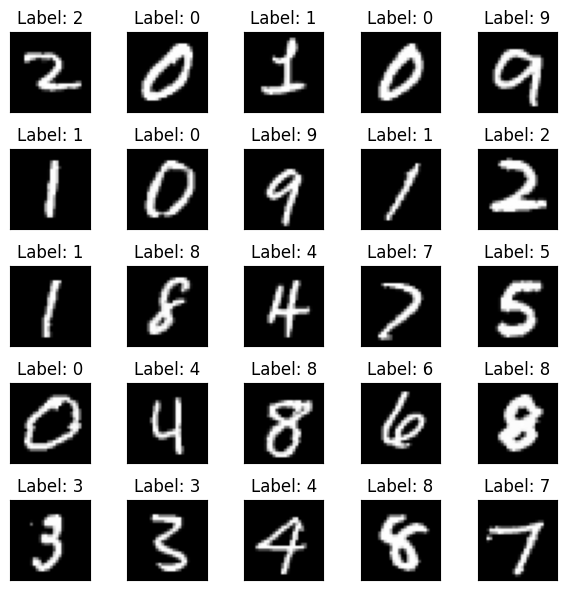

In [ ]:
fig, axs = plt.subplots(5, 5, figsize=(6,6))
for ax in axs.flatten():
    img, label = random.choice(train_dataset)
    ax.imshow(np.array(img), cmap='gist_gray')
    ax.set_title('Label: %d' % label)
    ax.set_xticks([])
    ax.set_yticks([])
plt.tight_layout()

In [ ]:
class AddGaussianNoise(object):
    def __init__(self, mean=0., std=0.2):
        self.mean = mean
        self.std = std

    def __call__(self, tensor):
        return tensor + torch.randn(tensor.size()) * self.std + self.mean

    def __repr__(self):
        return self.__class__.__name__ + f'(mean={self.mean}, std={self.std})'


In [ ]:
# data to tensors
train_transform = transforms.Compose([
    transforms.ToTensor(),
    AddGaussianNoise(0., 0.2)  # Додаємо шум
])
test_transform = transforms.Compose([
    transforms.ToTensor(),
])

# Set the train transform
train_dataset.transform = train_transform
# Set the test transform
test_dataset.transform = test_transform

In [ ]:
m=len(train_dataset)
train_data, val_data = random_split(train_dataset, [int(len(train_dataset)*0.8), int(m*0.2)])



In [ ]:
batch_size=256

train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size)
valid_loader = torch.utils.data.DataLoader(val_data, batch_size=batch_size)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size,shuffle=True)


In [ ]:
class Encoder(nn.Module):
    def __init__(self, encoded_space_dim):
        super().__init__()

        # Convolutional section
        self.encoder_cnn = nn.Sequential(
            nn.Conv2d(1, 8, 3, stride=2, padding=1),
            nn.ReLU(True),
            nn.Conv2d(8, 16, 3, stride=2, padding=1),
            nn.BatchNorm2d(16),
            nn.ReLU(True),
            nn.Conv2d(16, 32, 3, stride=2, padding=0),
            nn.ReLU(True)
        )

        # Flatten layer
        self.flatten = nn.Flatten(start_dim=1)

        # Linear section
        self.encoder_lin = nn.Sequential(
            nn.Linear(3 * 3 * 32, 128),
            nn.ReLU(True),
            nn.Linear(128, encoded_space_dim)
        )

    def forward(self, x):
        x = self.encoder_cnn(x)
        x = self.flatten(x)
        x = self.encoder_lin(x)
        return x

In [ ]:
class Decoder(nn.Module):
    def __init__(self, encoded_space_dim, fc2_input_dim=128):
        super().__init__()

        # Linear section
        self.decoder_lin = nn.Sequential(
            nn.Linear(encoded_space_dim, 128),
            nn.ReLU(True),
            nn.Linear(128, 7 * 7 * 16),  # Змінено для 7x7x16
            nn.ReLU(True)
        )

        self.unflatten = nn.Unflatten(dim=1, unflattened_size=(16, 7, 7))

        self.decoder_conv = nn.Sequential(
            nn.ConvTranspose2d(16, 8, 4, stride=2, padding=1),  # 7x7 -> 14x14
            nn.BatchNorm2d(8),
            nn.ReLU(True),
            nn.ConvTranspose2d(8, 1, 4, stride=2, padding=1)  # 14x14 -> 28x28
        )

    def forward(self, x):
        x = self.decoder_lin(x)
        x = self.unflatten(x)
        x = self.decoder_conv(x)
        x = torch.sigmoid(x)
        return x

In [ ]:
# Set the random seed for reproducible results
torch.manual_seed(42)

# Initialize the two networks
encoded_space_dim = 4  # Розмір закодованого простору
encoder = Encoder(encoded_space_dim=encoded_space_dim)
decoder = Decoder(encoded_space_dim=encoded_space_dim)

In [ ]:
img, _ = test_dataset[0]
img = img.unsqueeze(0) # Add the batch dimension in the first axis
print('Original image shape:', img.shape)

# Encode the image
img_enc = encoder(img)
print('Encoded image shape:', img_enc.shape)

# Decode the image
dec_img = decoder(img_enc)
print('Decoded image shape:', dec_img.shape)


Original image shape: torch.Size([1, 1, 28, 28])
Encoded image shape: torch.Size([1, 4])
Decoded image shape: torch.Size([1, 1, 28, 28])


In [ ]:
# Define the loss function
loss_fn = torch.nn.MSELoss()

# Define an optimizer (both for the encoder and the decoder!)
lr= 0.001

params_to_optimize = [
    {'params': encoder.parameters()},
    {'params': decoder.parameters()}
]

optim = torch.optim.Adam(params_to_optimize, lr=lr, weight_decay=1e-05)

# Check if the GPU is available
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
print(f'Selected device: {device}')

# Move both the encoder and the decoder to the selected device
encoder.to(device)


Selected device: cuda


Encoder(
  (encoder_cnn): Sequential(
    (0): Conv2d(1, 8, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(8, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (3): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): ReLU(inplace=True)
    (5): Conv2d(16, 32, kernel_size=(3, 3), stride=(2, 2))
    (6): ReLU(inplace=True)
  )
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (encoder_lin): Sequential(
    (0): Linear(in_features=288, out_features=128, bias=True)
    (1): ReLU(inplace=True)
    (2): Linear(in_features=128, out_features=4, bias=True)
  )
)

In [ ]:
decoder.to(device)


Decoder(
  (decoder_lin): Sequential(
    (0): Linear(in_features=4, out_features=128, bias=True)
    (1): ReLU(inplace=True)
    (2): Linear(in_features=128, out_features=784, bias=True)
    (3): ReLU(inplace=True)
  )
  (unflatten): Unflatten(dim=1, unflattened_size=(16, 7, 7))
  (decoder_conv): Sequential(
    (0): ConvTranspose2d(16, 8, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (1): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): ConvTranspose2d(8, 1, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
  )
)

In [ ]:
def train_epoch(encoder, decoder, device, dataloader, loss_fn, optimizer):
    # Set train mode for both the encoder and the decoder
    encoder.train()
    decoder.train()
    train_loss = []
    # Iterate the dataloader (we do not need the label values, this is unsupervised learning)
    for image_batch, _ in dataloader: # with "_" we just ignore the labels (the second element of the dataloader tuple)
        # Move tensor to the proper device
        image_batch = image_batch.to(device)
        clean_batch = image_batch.clone()
        # Encode data
        encoded_data = encoder(image_batch)
        # Decode data
        decoded_data = decoder(encoded_data)
        # Evaluate loss
        loss = loss_fn(decoded_data, clean_batch)
        # Backward pass
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        # Print batch loss
        print('\\t partial train loss (single batch): %f' % (loss.data))
        train_loss.append(loss.detach().cpu().numpy())

    return np.mean(train_loss)
def test_epoch(encoder, decoder, device, dataloader, loss_fn):
    # Set evaluation mode for encoder and decoder
    encoder.eval()
    decoder.eval()
    with torch.no_grad(): # No need to track the gradients
        # Define the lists to store the outputs for each batch
        conc_out = []
        conc_label = []
        for image_batch, _ in dataloader:
            # Move tensor to the proper device
            image_batch = image_batch.to(device)
            # Encode data
            encoded_data = encoder(image_batch)
            # Decode data
            decoded_data = decoder(encoded_data)
            # Append the network output and the original image to the lists
            conc_out.append(decoded_data.cpu())
            conc_label.append(image_batch.cpu())
        # Create a single tensor with all the values in the lists
        conc_out = torch.cat(conc_out)
        conc_label = torch.cat(conc_label)
        # Evaluate global loss
        val_loss = loss_fn(conc_out, conc_label)
    return val_loss.data


In [ ]:
def plot_ae_outputs(encoder, decoder, n=5):
    plt.figure(figsize=(10, 6))
    for i in range(n):
        img = test_dataset[i][0].unsqueeze(0).to(device)
        noisy_img = img + torch.randn_like(img) * 0.2  # додаємо шум вручну

        ax = plt.subplot(3, n, i + 1)
        plt.imshow(img.cpu().squeeze(), cmap='gist_gray')
        ax.set_title('Original')
        ax.axis('off')

        ax = plt.subplot(3, n, i + 1 + n)
        plt.imshow(noisy_img.cpu().squeeze(), cmap='gist_gray')
        ax.set_title('Noisy')
        ax.axis('off')

        encoder.eval()
        decoder.eval()
        with torch.no_grad():
            rec_img = decoder(encoder(noisy_img))

        ax = plt.subplot(3, n, i + 1 + 2 * n)
        plt.imshow(rec_img.cpu().squeeze(), cmap='gist_gray')
        ax.set_title('Reconstructed')
        ax.axis('off')
    plt.tight_layout()
    plt.show()


\t partial train loss (single batch): 0.373214
\t partial train loss (single batch): 0.361934
\t partial train loss (single batch): 0.352711
\t partial train loss (single batch): 0.345698
\t partial train loss (single batch): 0.339844
\t partial train loss (single batch): 0.334368
\t partial train loss (single batch): 0.329317
\t partial train loss (single batch): 0.324427
\t partial train loss (single batch): 0.318023
\t partial train loss (single batch): 0.315605
\t partial train loss (single batch): 0.311372
\t partial train loss (single batch): 0.307768
\t partial train loss (single batch): 0.304334
\t partial train loss (single batch): 0.301177
\t partial train loss (single batch): 0.298125
\t partial train loss (single batch): 0.294331
\t partial train loss (single batch): 0.291108
\t partial train loss (single batch): 0.287742
\t partial train loss (single batch): 0.285876
\t partial train loss (single batch): 0.283218
\t partial train loss (single batch): 0.279779
\t partial tr

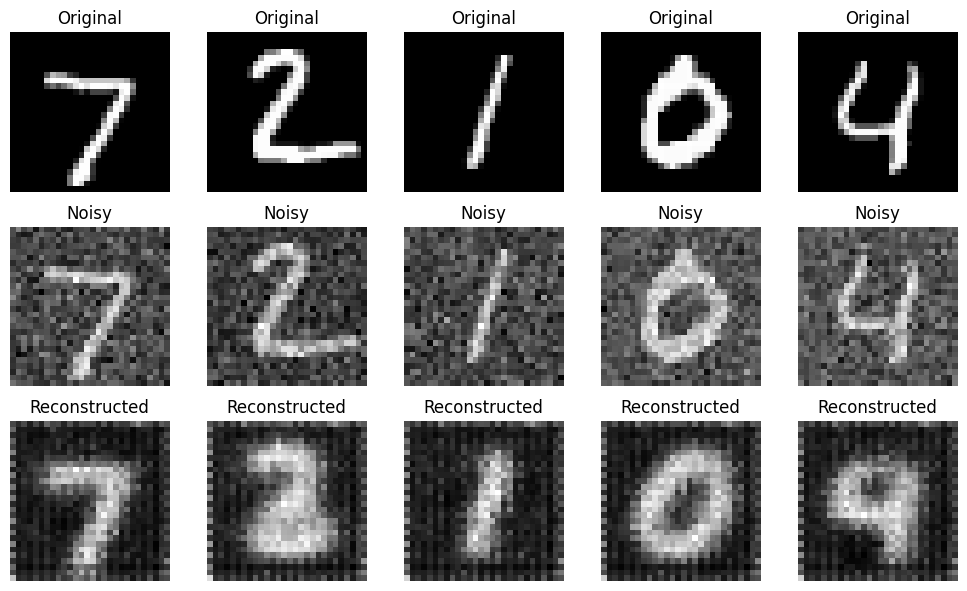

\t partial train loss (single batch): 0.100997
\t partial train loss (single batch): 0.100797
\t partial train loss (single batch): 0.100812
\t partial train loss (single batch): 0.100133
\t partial train loss (single batch): 0.100523
\t partial train loss (single batch): 0.100363
\t partial train loss (single batch): 0.099546
\t partial train loss (single batch): 0.099748
\t partial train loss (single batch): 0.099335
\t partial train loss (single batch): 0.099250
\t partial train loss (single batch): 0.098493
\t partial train loss (single batch): 0.097535
\t partial train loss (single batch): 0.097736
\t partial train loss (single batch): 0.097665
\t partial train loss (single batch): 0.098290
\t partial train loss (single batch): 0.097716
\t partial train loss (single batch): 0.096454
\t partial train loss (single batch): 0.097527
\t partial train loss (single batch): 0.097253
\t partial train loss (single batch): 0.095797
\t partial train loss (single batch): 0.096712
\t partial tr

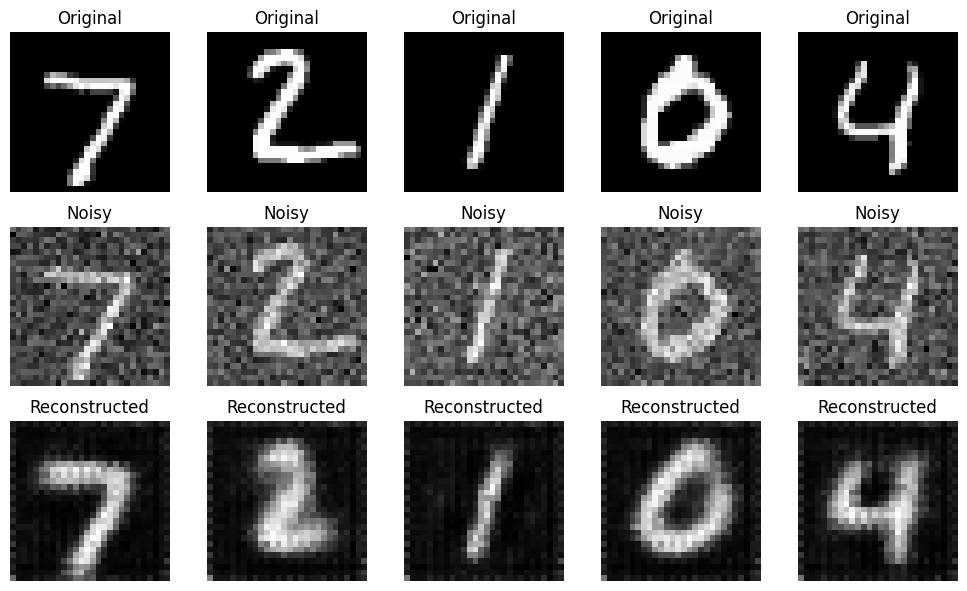

\t partial train loss (single batch): 0.080702
\t partial train loss (single batch): 0.080038
\t partial train loss (single batch): 0.079629
\t partial train loss (single batch): 0.080061
\t partial train loss (single batch): 0.080932
\t partial train loss (single batch): 0.080272
\t partial train loss (single batch): 0.080606
\t partial train loss (single batch): 0.079963
\t partial train loss (single batch): 0.080097
\t partial train loss (single batch): 0.080860
\t partial train loss (single batch): 0.078733
\t partial train loss (single batch): 0.077955
\t partial train loss (single batch): 0.078980
\t partial train loss (single batch): 0.078794
\t partial train loss (single batch): 0.079687
\t partial train loss (single batch): 0.079520
\t partial train loss (single batch): 0.077856
\t partial train loss (single batch): 0.079794
\t partial train loss (single batch): 0.079884
\t partial train loss (single batch): 0.078852
\t partial train loss (single batch): 0.079754
\t partial tr

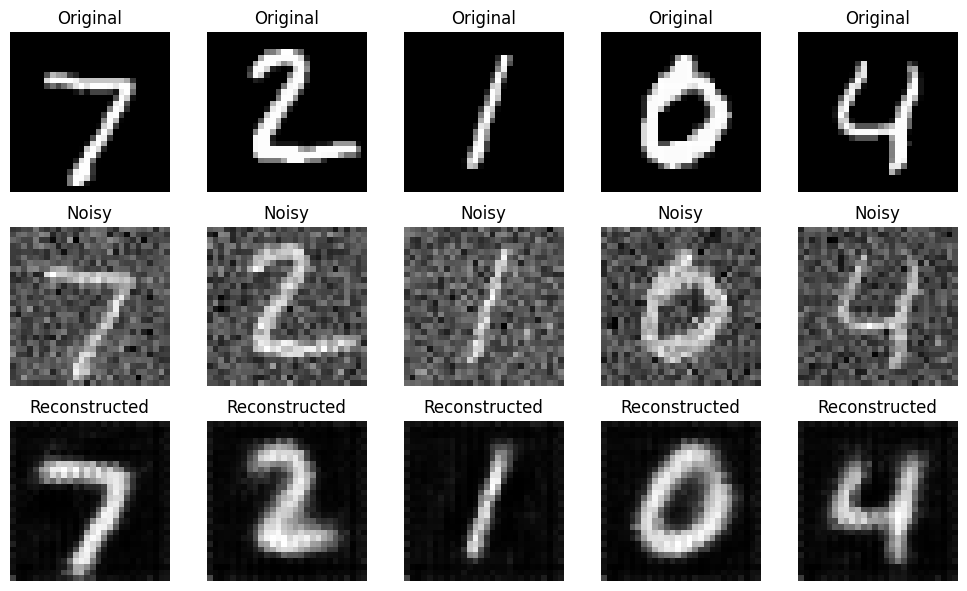

\t partial train loss (single batch): 0.074457
\t partial train loss (single batch): 0.074658
\t partial train loss (single batch): 0.074188
\t partial train loss (single batch): 0.074205
\t partial train loss (single batch): 0.075201
\t partial train loss (single batch): 0.074908
\t partial train loss (single batch): 0.075068
\t partial train loss (single batch): 0.074863
\t partial train loss (single batch): 0.074305
\t partial train loss (single batch): 0.075474
\t partial train loss (single batch): 0.073452
\t partial train loss (single batch): 0.072635
\t partial train loss (single batch): 0.074026
\t partial train loss (single batch): 0.073025
\t partial train loss (single batch): 0.074469
\t partial train loss (single batch): 0.074091
\t partial train loss (single batch): 0.072591
\t partial train loss (single batch): 0.074419
\t partial train loss (single batch): 0.074420
\t partial train loss (single batch): 0.074349
\t partial train loss (single batch): 0.074357
\t partial tr

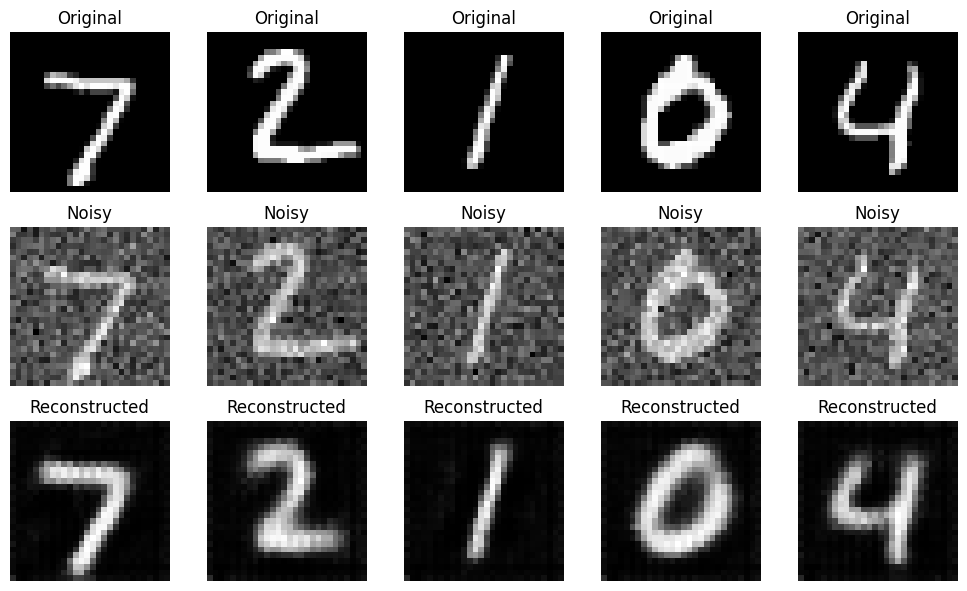

\t partial train loss (single batch): 0.072560
\t partial train loss (single batch): 0.071679
\t partial train loss (single batch): 0.071361
\t partial train loss (single batch): 0.071880
\t partial train loss (single batch): 0.072698
\t partial train loss (single batch): 0.071840
\t partial train loss (single batch): 0.072660
\t partial train loss (single batch): 0.072306
\t partial train loss (single batch): 0.072472
\t partial train loss (single batch): 0.072903
\t partial train loss (single batch): 0.070942
\t partial train loss (single batch): 0.070445
\t partial train loss (single batch): 0.071508
\t partial train loss (single batch): 0.070617
\t partial train loss (single batch): 0.072176
\t partial train loss (single batch): 0.071983
\t partial train loss (single batch): 0.070230
\t partial train loss (single batch): 0.072106
\t partial train loss (single batch): 0.071765
\t partial train loss (single batch): 0.071612
\t partial train loss (single batch): 0.072257
\t partial tr

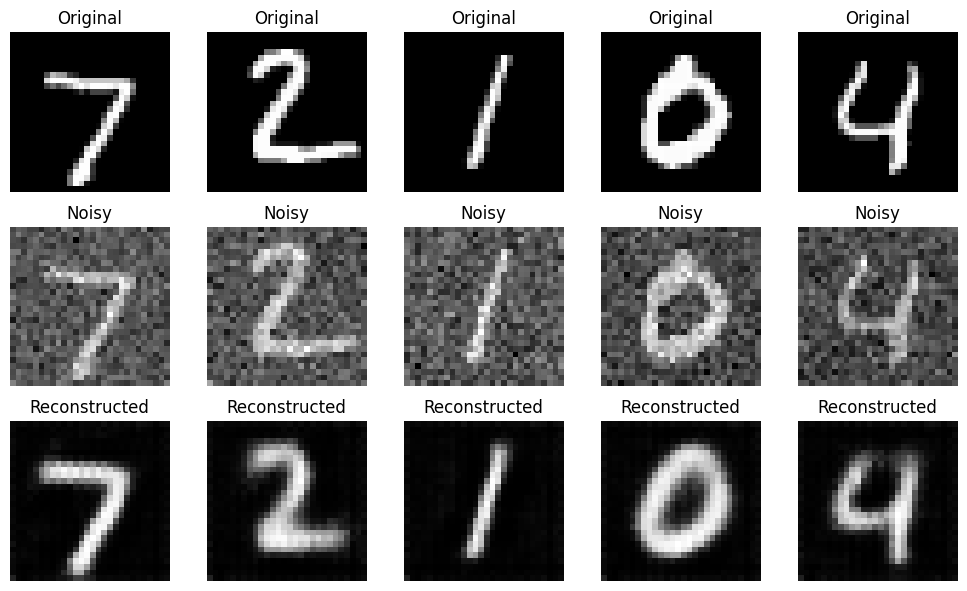

\t partial train loss (single batch): 0.070988
\t partial train loss (single batch): 0.070273
\t partial train loss (single batch): 0.070116
\t partial train loss (single batch): 0.070546
\t partial train loss (single batch): 0.071677
\t partial train loss (single batch): 0.071212
\t partial train loss (single batch): 0.071477
\t partial train loss (single batch): 0.071091
\t partial train loss (single batch): 0.070799
\t partial train loss (single batch): 0.071341
\t partial train loss (single batch): 0.069939
\t partial train loss (single batch): 0.069246
\t partial train loss (single batch): 0.070435
\t partial train loss (single batch): 0.069642
\t partial train loss (single batch): 0.070561
\t partial train loss (single batch): 0.070694
\t partial train loss (single batch): 0.069052
\t partial train loss (single batch): 0.071327
\t partial train loss (single batch): 0.071170
\t partial train loss (single batch): 0.070180
\t partial train loss (single batch): 0.071110
\t partial tr

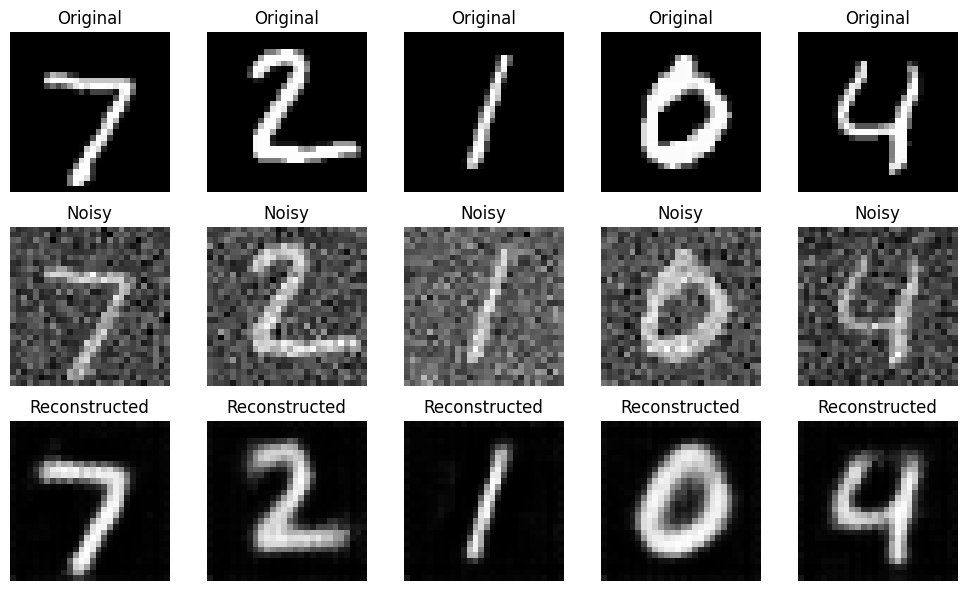

\t partial train loss (single batch): 0.069937
\t partial train loss (single batch): 0.069591
\t partial train loss (single batch): 0.069467
\t partial train loss (single batch): 0.070181
\t partial train loss (single batch): 0.070697
\t partial train loss (single batch): 0.070287
\t partial train loss (single batch): 0.070021
\t partial train loss (single batch): 0.069825
\t partial train loss (single batch): 0.070069
\t partial train loss (single batch): 0.070560
\t partial train loss (single batch): 0.068807
\t partial train loss (single batch): 0.068735
\t partial train loss (single batch): 0.069947
\t partial train loss (single batch): 0.069087
\t partial train loss (single batch): 0.070232
\t partial train loss (single batch): 0.069995
\t partial train loss (single batch): 0.068108
\t partial train loss (single batch): 0.070276
\t partial train loss (single batch): 0.069942
\t partial train loss (single batch): 0.069311
\t partial train loss (single batch): 0.070241
\t partial tr

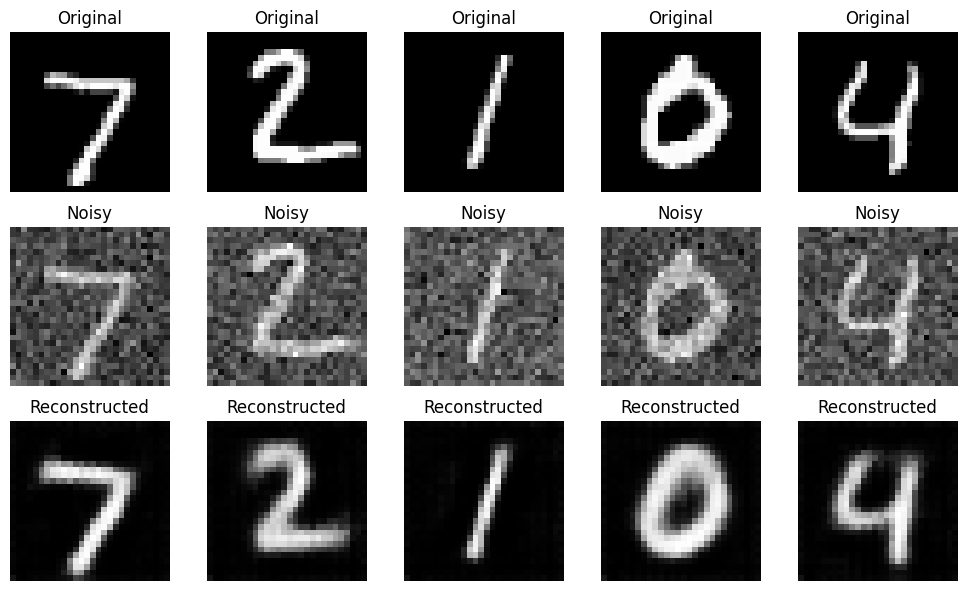

\t partial train loss (single batch): 0.069948
\t partial train loss (single batch): 0.069013
\t partial train loss (single batch): 0.068960
\t partial train loss (single batch): 0.069820
\t partial train loss (single batch): 0.070127
\t partial train loss (single batch): 0.069751
\t partial train loss (single batch): 0.069507
\t partial train loss (single batch): 0.069657
\t partial train loss (single batch): 0.069177
\t partial train loss (single batch): 0.070209
\t partial train loss (single batch): 0.068382
\t partial train loss (single batch): 0.068047
\t partial train loss (single batch): 0.069009
\t partial train loss (single batch): 0.067883
\t partial train loss (single batch): 0.069045
\t partial train loss (single batch): 0.069566
\t partial train loss (single batch): 0.067863
\t partial train loss (single batch): 0.069406
\t partial train loss (single batch): 0.069999
\t partial train loss (single batch): 0.068987
\t partial train loss (single batch): 0.070165
\t partial tr

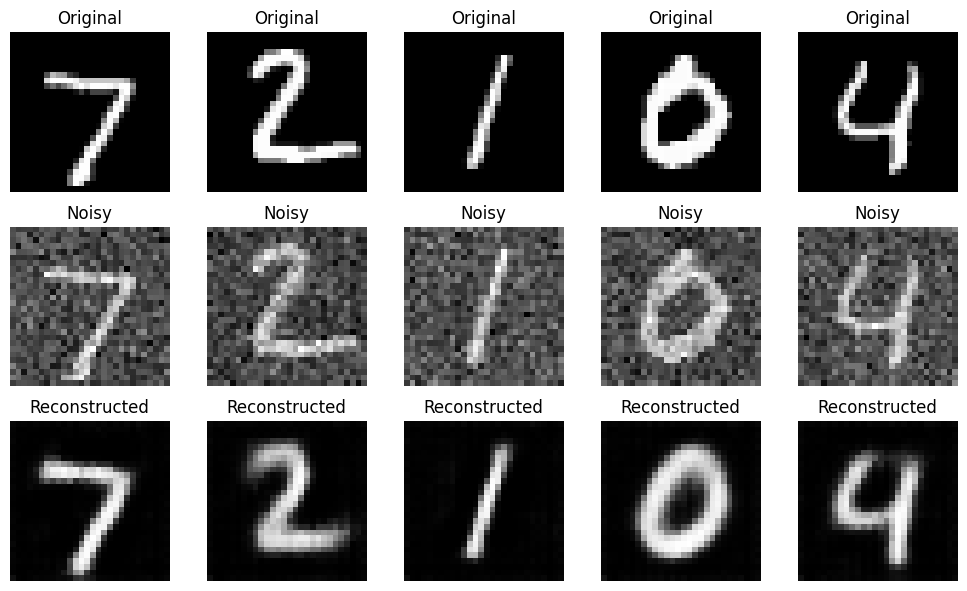

\t partial train loss (single batch): 0.069256
\t partial train loss (single batch): 0.068624
\t partial train loss (single batch): 0.068930
\t partial train loss (single batch): 0.069357
\t partial train loss (single batch): 0.069430
\t partial train loss (single batch): 0.068914
\t partial train loss (single batch): 0.068903
\t partial train loss (single batch): 0.069283
\t partial train loss (single batch): 0.069110
\t partial train loss (single batch): 0.069505
\t partial train loss (single batch): 0.067749
\t partial train loss (single batch): 0.067719
\t partial train loss (single batch): 0.068889
\t partial train loss (single batch): 0.067888
\t partial train loss (single batch): 0.069030
\t partial train loss (single batch): 0.069301
\t partial train loss (single batch): 0.067549
\t partial train loss (single batch): 0.069304
\t partial train loss (single batch): 0.069352
\t partial train loss (single batch): 0.068147
\t partial train loss (single batch): 0.070221
\t partial tr

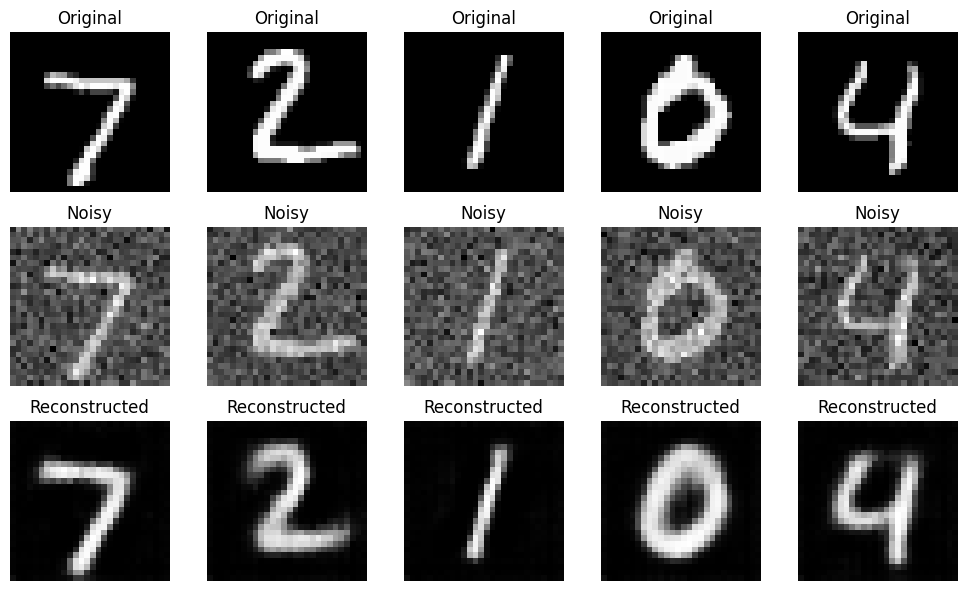

\t partial train loss (single batch): 0.068365
\t partial train loss (single batch): 0.068146
\t partial train loss (single batch): 0.068366
\t partial train loss (single batch): 0.068941
\t partial train loss (single batch): 0.069134
\t partial train loss (single batch): 0.068551
\t partial train loss (single batch): 0.068733
\t partial train loss (single batch): 0.069303
\t partial train loss (single batch): 0.068545
\t partial train loss (single batch): 0.069119
\t partial train loss (single batch): 0.067567
\t partial train loss (single batch): 0.067582
\t partial train loss (single batch): 0.068527
\t partial train loss (single batch): 0.067368
\t partial train loss (single batch): 0.068012
\t partial train loss (single batch): 0.068491
\t partial train loss (single batch): 0.067276
\t partial train loss (single batch): 0.068433
\t partial train loss (single batch): 0.069018
\t partial train loss (single batch): 0.067938
\t partial train loss (single batch): 0.069166
\t partial tr

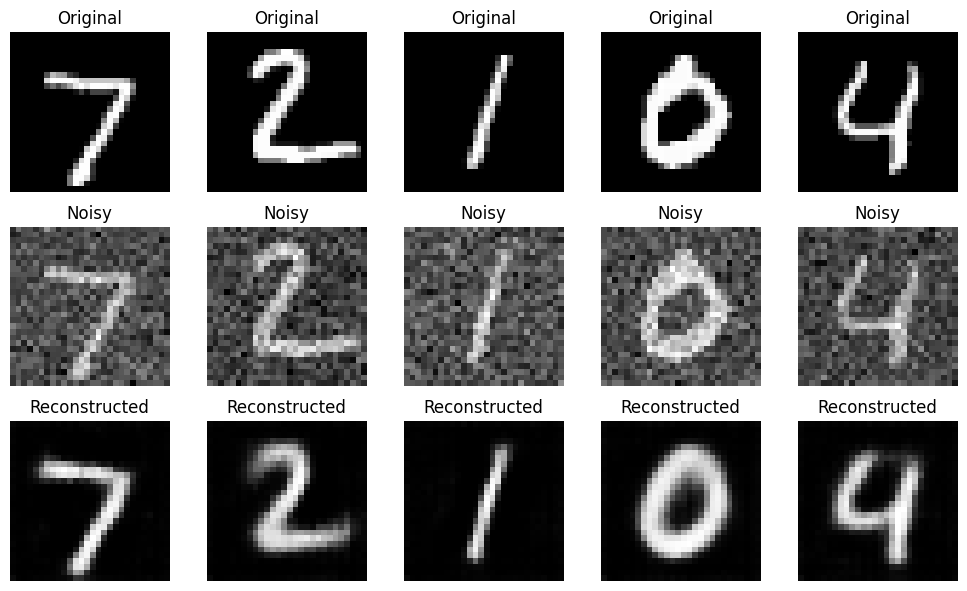

\t partial train loss (single batch): 0.067912
\t partial train loss (single batch): 0.067282
\t partial train loss (single batch): 0.068365
\t partial train loss (single batch): 0.068196
\t partial train loss (single batch): 0.068808
\t partial train loss (single batch): 0.068569
\t partial train loss (single batch): 0.067935
\t partial train loss (single batch): 0.068228
\t partial train loss (single batch): 0.068103
\t partial train loss (single batch): 0.068731
\t partial train loss (single batch): 0.067369
\t partial train loss (single batch): 0.067044
\t partial train loss (single batch): 0.067375
\t partial train loss (single batch): 0.067024
\t partial train loss (single batch): 0.068052
\t partial train loss (single batch): 0.068764
\t partial train loss (single batch): 0.066840
\t partial train loss (single batch): 0.068751
\t partial train loss (single batch): 0.068235
\t partial train loss (single batch): 0.068027
\t partial train loss (single batch): 0.069360
\t partial tr

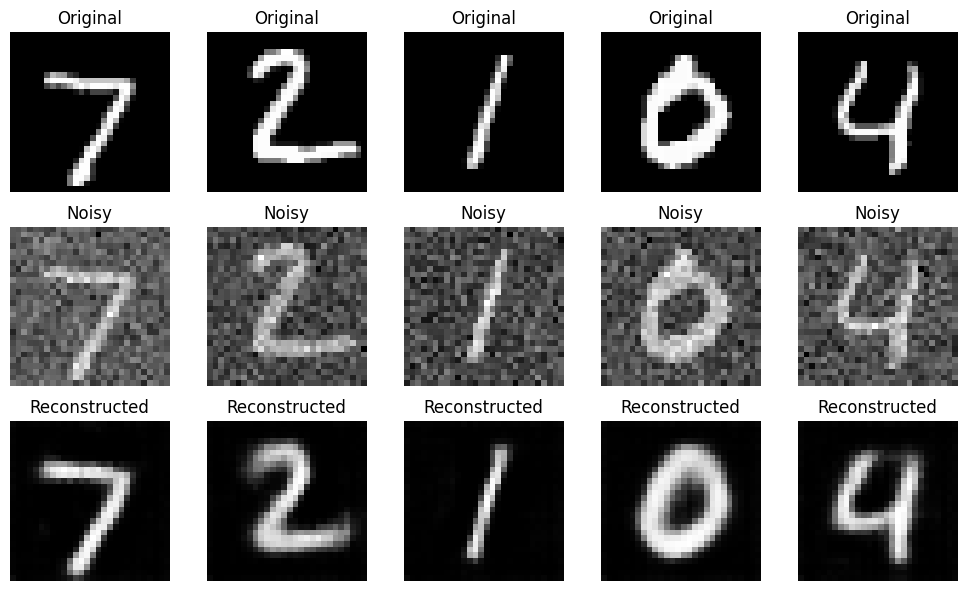

\t partial train loss (single batch): 0.067829
\t partial train loss (single batch): 0.067656
\t partial train loss (single batch): 0.067558
\t partial train loss (single batch): 0.067727
\t partial train loss (single batch): 0.068630
\t partial train loss (single batch): 0.068313
\t partial train loss (single batch): 0.068378
\t partial train loss (single batch): 0.068583
\t partial train loss (single batch): 0.068002
\t partial train loss (single batch): 0.068451
\t partial train loss (single batch): 0.067103
\t partial train loss (single batch): 0.066780
\t partial train loss (single batch): 0.067449
\t partial train loss (single batch): 0.066936
\t partial train loss (single batch): 0.067854
\t partial train loss (single batch): 0.068201
\t partial train loss (single batch): 0.066238
\t partial train loss (single batch): 0.068212
\t partial train loss (single batch): 0.067792
\t partial train loss (single batch): 0.067055
\t partial train loss (single batch): 0.068865
\t partial tr

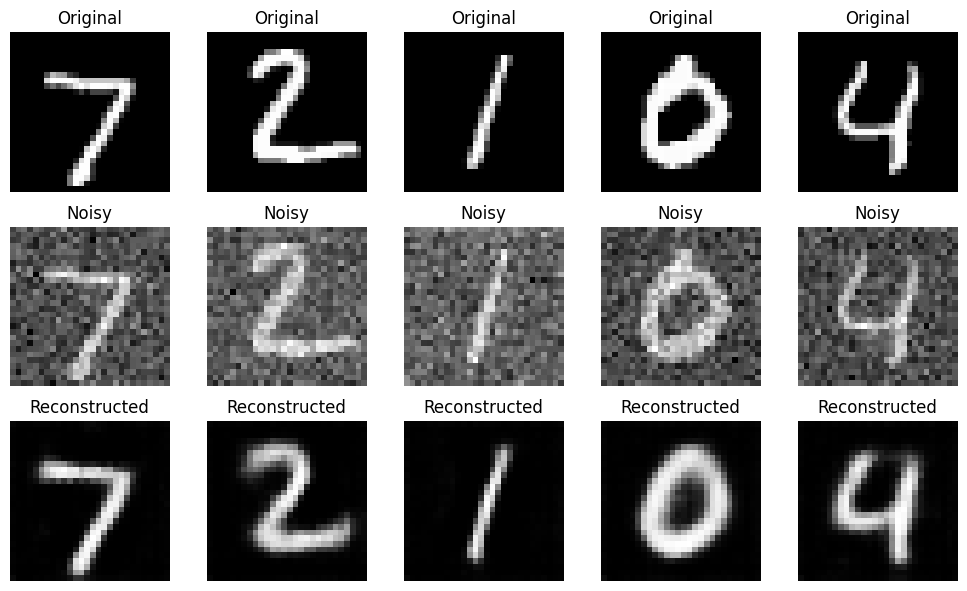

\t partial train loss (single batch): 0.067648
\t partial train loss (single batch): 0.066962
\t partial train loss (single batch): 0.067360
\t partial train loss (single batch): 0.068241
\t partial train loss (single batch): 0.068641
\t partial train loss (single batch): 0.068342
\t partial train loss (single batch): 0.067602
\t partial train loss (single batch): 0.067972
\t partial train loss (single batch): 0.067337
\t partial train loss (single batch): 0.068552
\t partial train loss (single batch): 0.066810
\t partial train loss (single batch): 0.066258
\t partial train loss (single batch): 0.067513
\t partial train loss (single batch): 0.066845
\t partial train loss (single batch): 0.067209
\t partial train loss (single batch): 0.068241
\t partial train loss (single batch): 0.066585
\t partial train loss (single batch): 0.068514
\t partial train loss (single batch): 0.067650
\t partial train loss (single batch): 0.067482
\t partial train loss (single batch): 0.068770
\t partial tr

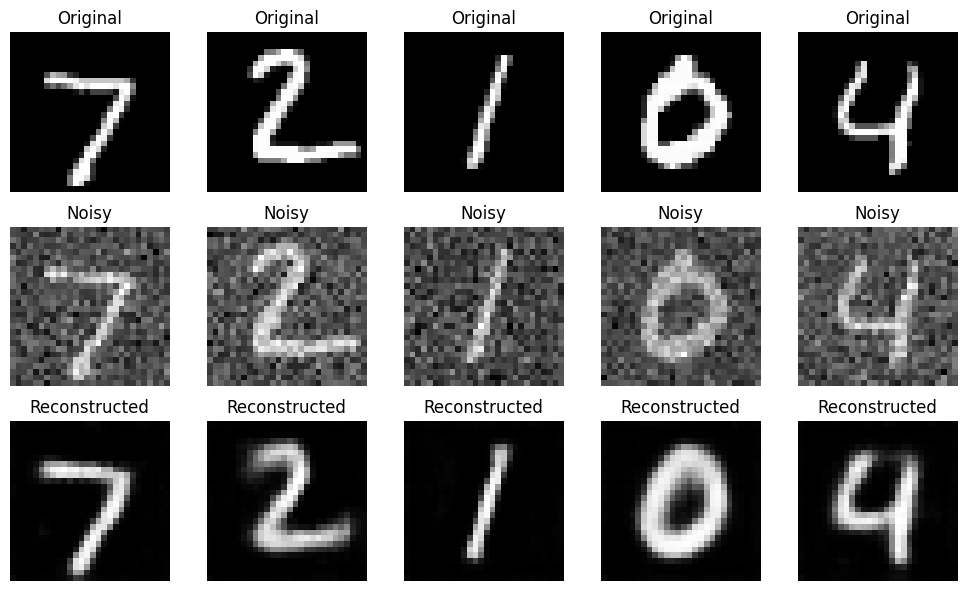

\t partial train loss (single batch): 0.067157
\t partial train loss (single batch): 0.067231
\t partial train loss (single batch): 0.067450
\t partial train loss (single batch): 0.067610
\t partial train loss (single batch): 0.068012
\t partial train loss (single batch): 0.067787
\t partial train loss (single batch): 0.067586
\t partial train loss (single batch): 0.067461
\t partial train loss (single batch): 0.067624
\t partial train loss (single batch): 0.067847
\t partial train loss (single batch): 0.066439
\t partial train loss (single batch): 0.065947
\t partial train loss (single batch): 0.067242
\t partial train loss (single batch): 0.066615
\t partial train loss (single batch): 0.067332
\t partial train loss (single batch): 0.067720
\t partial train loss (single batch): 0.066492
\t partial train loss (single batch): 0.068223
\t partial train loss (single batch): 0.067796
\t partial train loss (single batch): 0.066629
\t partial train loss (single batch): 0.068608
\t partial tr

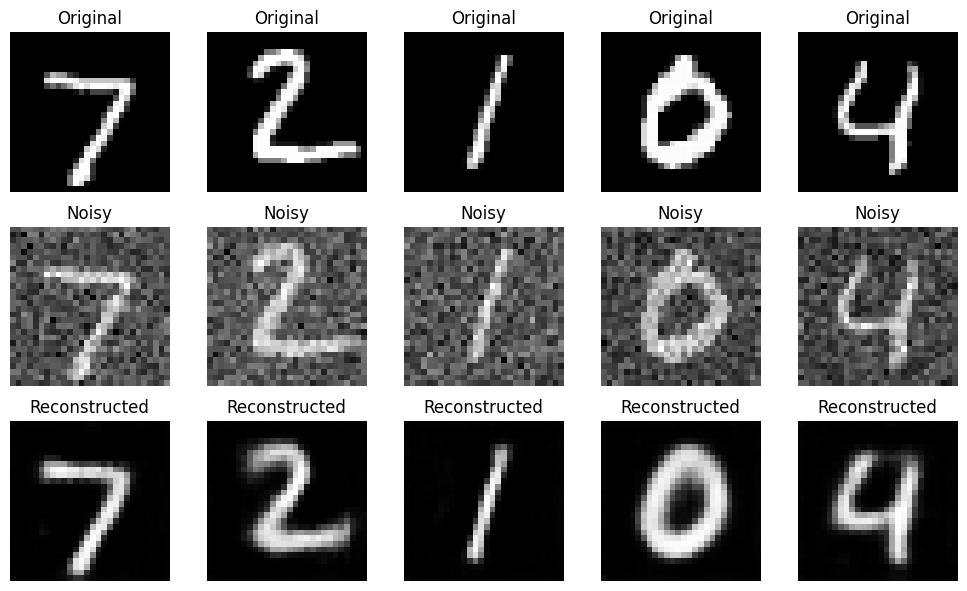

\t partial train loss (single batch): 0.067475
\t partial train loss (single batch): 0.067140
\t partial train loss (single batch): 0.067379
\t partial train loss (single batch): 0.067846
\t partial train loss (single batch): 0.067685
\t partial train loss (single batch): 0.067784
\t partial train loss (single batch): 0.067729
\t partial train loss (single batch): 0.067676
\t partial train loss (single batch): 0.067717
\t partial train loss (single batch): 0.068084
\t partial train loss (single batch): 0.066148
\t partial train loss (single batch): 0.066116
\t partial train loss (single batch): 0.067507
\t partial train loss (single batch): 0.066119
\t partial train loss (single batch): 0.067232
\t partial train loss (single batch): 0.067910
\t partial train loss (single batch): 0.066368
\t partial train loss (single batch): 0.068143
\t partial train loss (single batch): 0.067729
\t partial train loss (single batch): 0.066762
\t partial train loss (single batch): 0.068201
\t partial tr

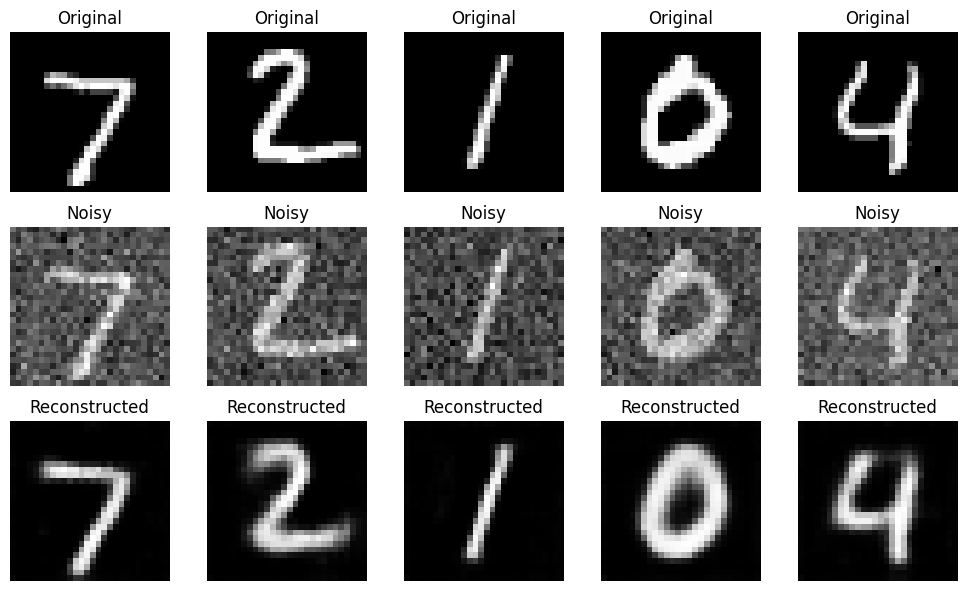

\t partial train loss (single batch): 0.066933
\t partial train loss (single batch): 0.067043
\t partial train loss (single batch): 0.066290
\t partial train loss (single batch): 0.067530
\t partial train loss (single batch): 0.067719
\t partial train loss (single batch): 0.067236
\t partial train loss (single batch): 0.067164
\t partial train loss (single batch): 0.067378
\t partial train loss (single batch): 0.067311
\t partial train loss (single batch): 0.067729
\t partial train loss (single batch): 0.066033
\t partial train loss (single batch): 0.065582
\t partial train loss (single batch): 0.067169
\t partial train loss (single batch): 0.066084
\t partial train loss (single batch): 0.066981
\t partial train loss (single batch): 0.067283
\t partial train loss (single batch): 0.065739
\t partial train loss (single batch): 0.067612
\t partial train loss (single batch): 0.067415
\t partial train loss (single batch): 0.067035
\t partial train loss (single batch): 0.068231
\t partial tr

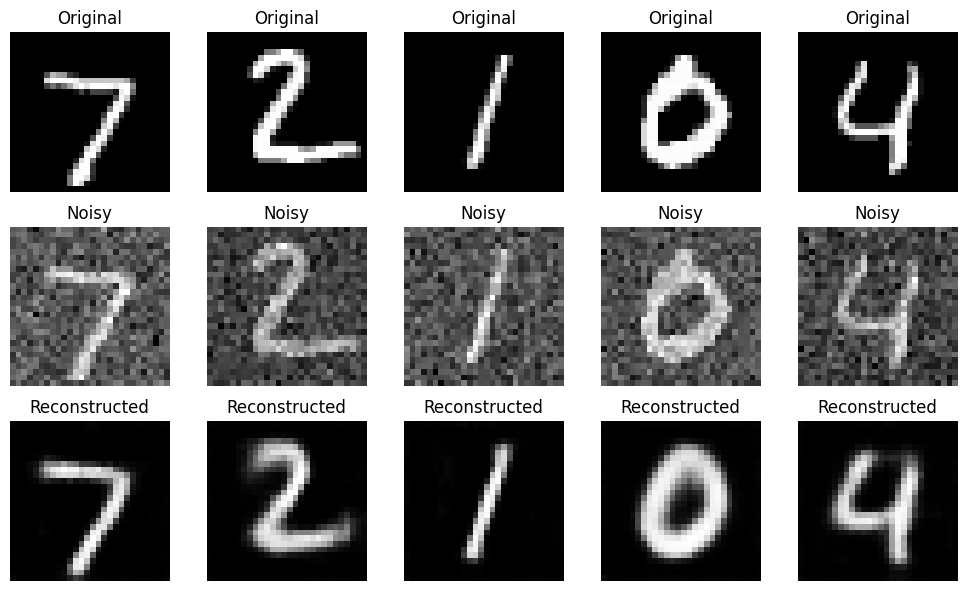

\t partial train loss (single batch): 0.066823
\t partial train loss (single batch): 0.066526
\t partial train loss (single batch): 0.067077
\t partial train loss (single batch): 0.067047
\t partial train loss (single batch): 0.067813
\t partial train loss (single batch): 0.066880
\t partial train loss (single batch): 0.067123
\t partial train loss (single batch): 0.067183
\t partial train loss (single batch): 0.067199
\t partial train loss (single batch): 0.067473
\t partial train loss (single batch): 0.065951
\t partial train loss (single batch): 0.065412
\t partial train loss (single batch): 0.066821
\t partial train loss (single batch): 0.065942
\t partial train loss (single batch): 0.066562
\t partial train loss (single batch): 0.066886
\t partial train loss (single batch): 0.065423
\t partial train loss (single batch): 0.066992
\t partial train loss (single batch): 0.066998
\t partial train loss (single batch): 0.066431
\t partial train loss (single batch): 0.067661
\t partial tr

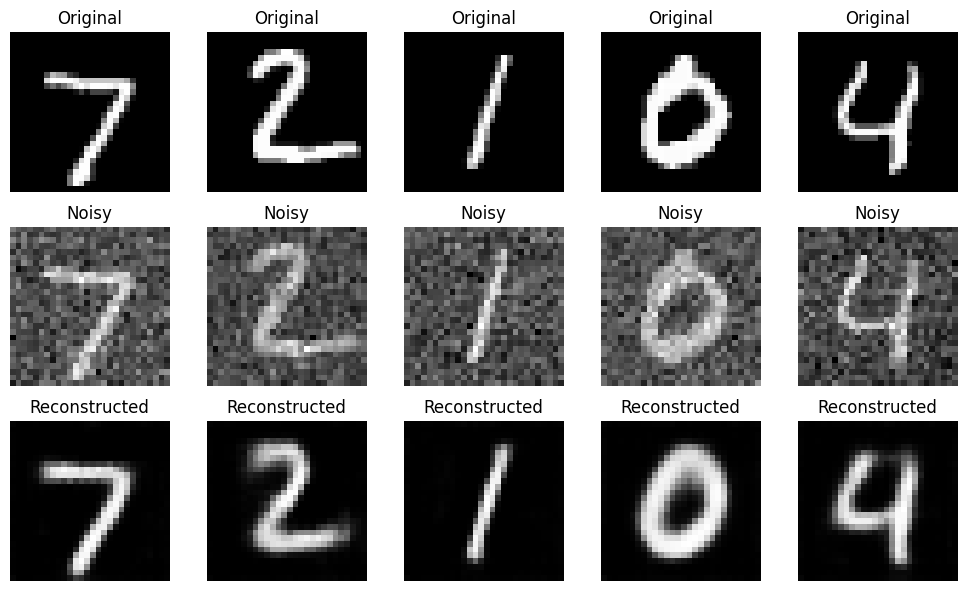

\t partial train loss (single batch): 0.067002
\t partial train loss (single batch): 0.066160
\t partial train loss (single batch): 0.066541
\t partial train loss (single batch): 0.066926
\t partial train loss (single batch): 0.068010
\t partial train loss (single batch): 0.067385
\t partial train loss (single batch): 0.067119
\t partial train loss (single batch): 0.067105
\t partial train loss (single batch): 0.067088
\t partial train loss (single batch): 0.067426
\t partial train loss (single batch): 0.065444
\t partial train loss (single batch): 0.065231
\t partial train loss (single batch): 0.066992
\t partial train loss (single batch): 0.065918
\t partial train loss (single batch): 0.066937
\t partial train loss (single batch): 0.067268
\t partial train loss (single batch): 0.065752
\t partial train loss (single batch): 0.067791
\t partial train loss (single batch): 0.067194
\t partial train loss (single batch): 0.066352
\t partial train loss (single batch): 0.067903
\t partial tr

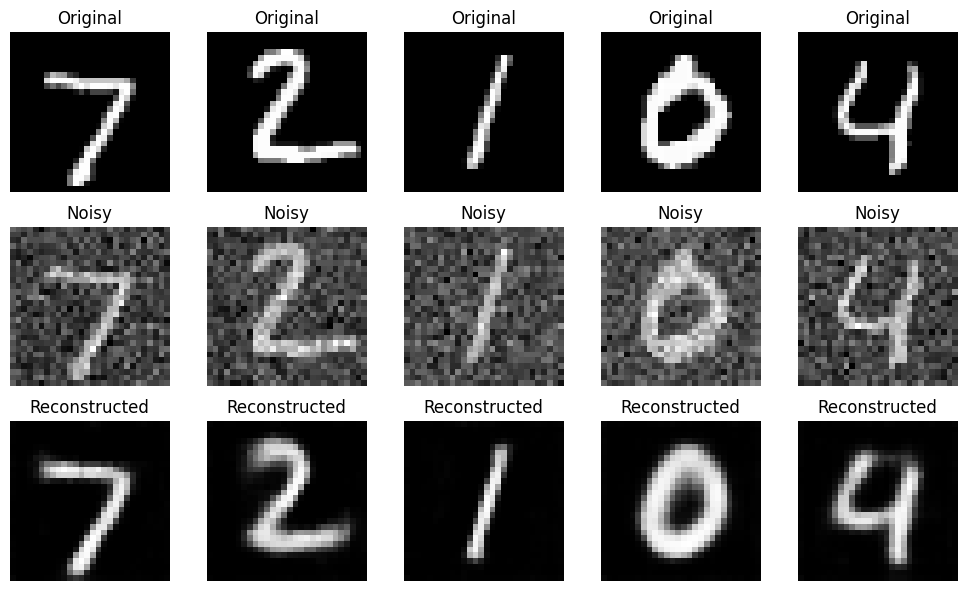

\t partial train loss (single batch): 0.066698
\t partial train loss (single batch): 0.066586
\t partial train loss (single batch): 0.066888
\t partial train loss (single batch): 0.066458
\t partial train loss (single batch): 0.067295
\t partial train loss (single batch): 0.066893
\t partial train loss (single batch): 0.066756
\t partial train loss (single batch): 0.067261
\t partial train loss (single batch): 0.066752
\t partial train loss (single batch): 0.067292
\t partial train loss (single batch): 0.065724
\t partial train loss (single batch): 0.065437
\t partial train loss (single batch): 0.067195
\t partial train loss (single batch): 0.065606
\t partial train loss (single batch): 0.066256
\t partial train loss (single batch): 0.066812
\t partial train loss (single batch): 0.065709
\t partial train loss (single batch): 0.066849
\t partial train loss (single batch): 0.066680
\t partial train loss (single batch): 0.066100
\t partial train loss (single batch): 0.067596
\t partial tr

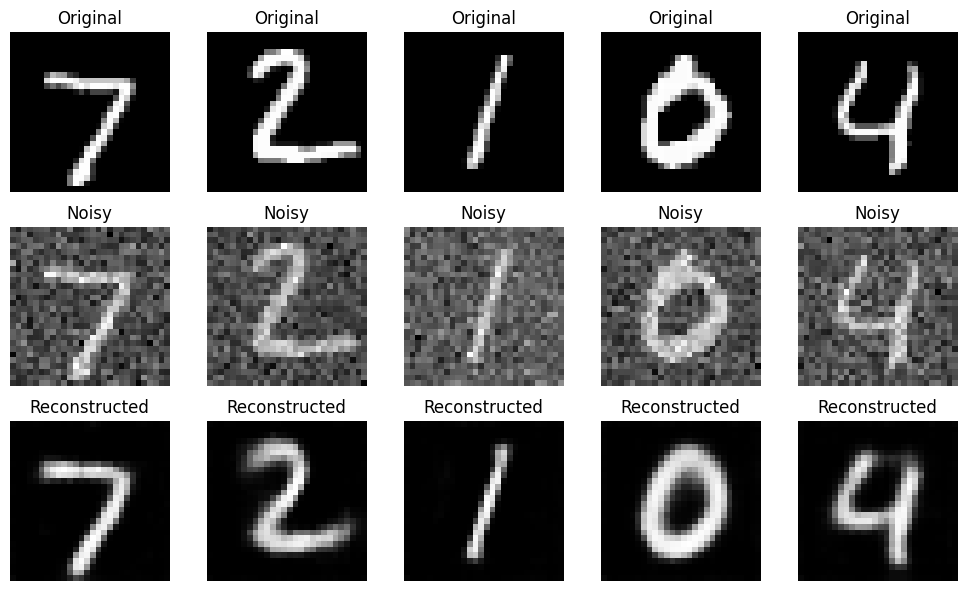

\t partial train loss (single batch): 0.067123
\t partial train loss (single batch): 0.066662
\t partial train loss (single batch): 0.066457
\t partial train loss (single batch): 0.066592
\t partial train loss (single batch): 0.067378
\t partial train loss (single batch): 0.066918
\t partial train loss (single batch): 0.066885
\t partial train loss (single batch): 0.067030
\t partial train loss (single batch): 0.066863
\t partial train loss (single batch): 0.067134
\t partial train loss (single batch): 0.065266
\t partial train loss (single batch): 0.064890
\t partial train loss (single batch): 0.066927
\t partial train loss (single batch): 0.065114
\t partial train loss (single batch): 0.066234
\t partial train loss (single batch): 0.066295
\t partial train loss (single batch): 0.065531
\t partial train loss (single batch): 0.067272
\t partial train loss (single batch): 0.066277
\t partial train loss (single batch): 0.065886
\t partial train loss (single batch): 0.067459
\t partial tr

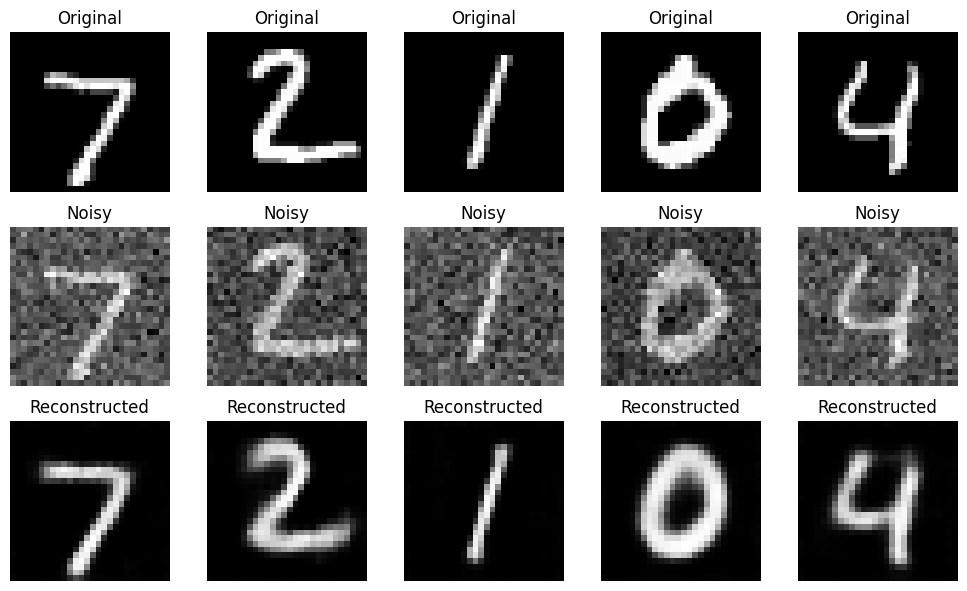

In [ ]:
num_epochs = 20
history={'train_loss':[],'val_loss':[]}

for epoch in range(num_epochs):
    train_loss = train_epoch(encoder,decoder,device,train_loader,loss_fn,optim)
    val_loss = test_epoch(encoder,decoder,device,valid_loader,loss_fn)

    print('\\n EPOCH {}/{} \\t train loss {:.3f} \\t val loss {:.3f}'.format(epoch + 1, num_epochs,train_loss,val_loss))

    history['train_loss'].append(train_loss)
    history['val_loss'].append(val_loss)
    plot_ae_outputs(encoder,decoder,n=5)


In [ ]:
test_epoch(encoder,decoder,device,test_loader,loss_fn).item()


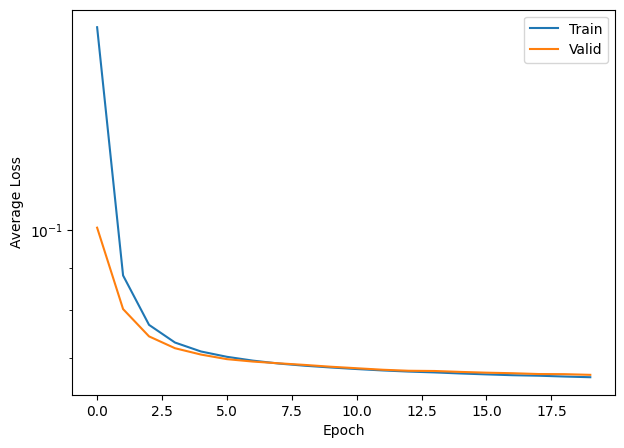

In [ ]:
# Train and validation loss

plt.figure(figsize=(7,5))
plt.semilogy(history['train_loss'], label='Train')
plt.semilogy(history['val_loss'], label='Valid')
plt.xlabel('Epoch')
plt.ylabel('Average Loss')
#plt.grid()
plt.legend()
#plt.title('loss')
plt.show()


Висновок:Модифікація автоенкодера для задач денoйзингу виявилася ефективною. Незважаючи на те, що модель навчалася на зашумлених даних, її здатність відновлювати чисті зображення (завдяки відповідній зміні функції навчання) була успішно продемонстрована. Результати свідчать про те, що автоенкодер набув стійкості до шуму та здатен якісно очищувати зображення.
